# Ada - Milestone 2
## 1. Preliminary data analysis
### Dataset: Beer reviews

### Understand data structure inside datasets
(From referenced paper in google sheets)

- Five stars / five-aspect rating system: **feel, look, smell, taste & overall**
- BA: 33 387 users, 66 051 beers, 1 586 259 reviews
- RB: 40 213 users, 110 419 beers, 2 924 127 reviews

'ba' system | 'rb' system
:----------:|:-----------:
![](../data/img/ba_rating_system.png) | ![](../data/img/rb_rating_system.png)

For both systems: 'rating' column (final score) is automatically generated based on the five aspects


In [37]:
import pandas as pd
import numpy as np
import os

# Visualization libraries
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

# Geospatial analysis
import geopandas as gpd


# import utils files
import src.utils.data_utils as data_utils
import src.utils.geospatial_utils as geospatial_utils
importlib.reload(data_utils)

DATA_FOLDER = "../data/"


Load the needed datasets

In [5]:
m_beers_raw = pd.read_csv(DATA_FOLDER + 'matched_beer_data/beers.csv', sep=',', header=[0, 1])
m_breweries_raw = pd.read_csv(DATA_FOLDER + 'matched_beer_data/breweries.csv', sep=',', header=[0, 1])
m_ratings_raw = pd.read_csv(DATA_FOLDER + 'matched_beer_data/ratings.csv', sep=',', header=[0, 1])

# # BA datasets
ba_users_raw = pd.read_csv(DATA_FOLDER + 'BeerAdvocate/users.csv', sep=',', header=[0])
ba_ratings_raw = data_utils.load_dict_like_text_file(DATA_FOLDER+'matched_beer_data/ratings_with_text_ba.txt',BLK_SIZE=20_000, MAX_BLK=1_000_000)
print("Size of 'ba' ratings dataframe: %d" % ba_ratings_raw.index.size)

# # RB datasets
rb_users_raw = pd.read_csv(DATA_FOLDER + 'RateBeer/users.csv', sep=',', header=[0])
rb_ratings_raw = data_utils.load_dict_like_text_file(DATA_FOLDER+'matched_beer_data/ratings_with_text_rb.txt',BLK_SIZE=20_000, MAX_BLK=3_000_000)
print("Size of 'rb' ratings dataframe: %d" % rb_ratings_raw.index.size)


LOADED 'ratings_with_text_ba.txt'                         
Size of 'ba' ratings dataframe: 289011
LOADED 'ratings_with_text_rb.txt'                         
Size of 'rb' ratings dataframe: 1020548


Create a dataframe to show the available columns in the datasets

In [6]:
col_info = pd.DataFrame({'ba_ratings_text': pd.Series(ba_ratings_raw.columns),
            'rb_ratings_text': pd.Series(rb_ratings_raw.columns),
            'beers_ba': pd.Series(m_beers_raw['ba'].columns.unique()),
            'beers_rb': pd.Series(m_beers_raw['rb'].columns.unique()),
            'breweries': pd.Series(m_breweries_raw['ba'].columns.unique()),
            'users_ba': pd.Series(ba_users_raw.columns.unique()),
            'users_rb': pd.Series(rb_users_raw.columns.unique()),
            'matched_ratings_ba': pd.Series(m_ratings_raw['ba'].columns.unique()),
            'matched_ratings_rb': pd.Series(m_ratings_raw['rb'].columns.unique())})
col_info

,ba_ratings_text,rb_ratings_text,beers_ba,beers_rb,breweries,users_ba,users_rb,matched_ratings_ba,matched_ratings_rb
0,beer_name,beer_name,abv,abv,id,nbr_ratings,nbr_ratings,abv,abv
1,beer_id,beer_id,avg,avg,location,nbr_reviews,user_id,appearance,appearance
2,brewery_name,brewery_name,avg_computed,avg_computed,name,user_id,user_name,aroma,aroma
3,brewery_id,brewery_id,avg_matched_valid_ratings,avg_matched_valid_ratings,nbr_beers,user_name,joined,beer_id,beer_id
4,style,style,ba_score,beer_id,NaN,joined,location,beer_name,beer_name
5,abv,abv,beer_id,beer_name,NaN,location,NaN,brewery_id,brewery_id
6,date,date,beer_name,beer_wout_brewery_name,NaN,NaN,NaN,brewery_name,brewery_name
7,user_name,user_name,beer_wout_brewery_name,brewery_id,NaN,NaN,NaN,date,date
8,user_id,user_id,brewery_id,brewery_name,NaN,NaN,NaN,overall,overall
9,appearance,appearance,brewery_name,nbr_matched_valid_ratings,NaN,NaN,NaN,palate,palate


## Creating a personalized dataset
Analyzing and merging the reviews with text from 'ba' and 'rb' datasets for maxizing the number of ratings to be used in our analysis

In [7]:
# Only different column from rb and ba is the 'review'
# Let's dive in to see what it contains
print("------ Values of this mysterious 'review' column -------")

display(ba_ratings_raw['review'].value_counts())

print("Interesting, some of the review values are false. What does it mean? Verifying if some of the values are NaN:")
display(ba_ratings_raw[ba_ratings_raw.review == 'False'].isna().sum())
print("None of the columns contains NaN values. CONCLUSION: DROP this useless column!\n")

ba_ratings = ba_ratings_raw.copy()
rb_ratings = rb_ratings_raw.copy()
ba_ratings.drop('review', axis=1, inplace=True)
print("----- Adjusted columns for ba and rb ratings -------")
display(pd.DataFrame([ba_ratings.columns, rb_ratings_raw.columns]))


------ Values of this mysterious 'review' column -------


review
True     272814
False     16197
Name: count, dtype: int64

Interesting, some of the review values are false. What does it mean? Verifying if some of the values are NaN:


beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
abv             0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            0
review          0
dtype: int64

None of the columns contains NaN values. CONCLUSION: DROP this useless column!

----- Adjusted columns for ba and rb ratings -------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
1,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text


---

### A. Merge rb and ba ratings with text in a single dataframe

**Before** merging, normalize all score data to have same basis (Some are over /5 /10 or even /20)!

In [8]:
# Limit floating point decimals output
pd.options.display.float_format = '{:.2f}'.format

# Perform normalization of data
# First, adjust data types to float for ratings
cols = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
rb_ratings[cols] = rb_ratings[cols].astype(float)
ba_ratings[cols] = ba_ratings[cols].astype(float)

print("------ RB Stats (before normalization) -------")
display(rb_ratings.describe())
print("------ BA Stats (before normalization) -------")
display(ba_ratings.describe())

# Second, normalize all scores /5 (Only 'overall', 'taste', 'aroma' are different)
rb_ratings['overall'] = rb_ratings['overall'] / 4
rb_ratings[['taste', 'aroma']] = rb_ratings[['taste', 'aroma']] / 2

print("------ RB Stats (after normalization) -------")
display(rb_ratings.describe())
print("------ BA Stats (after normalization) -------")
display(ba_ratings.describe())

# Join rb and ba users dataframe to have access to location
rb_ratings.loc[:, 'user_id'] = rb_ratings.loc[:, 'user_id'].astype(int)
rb_ratings.drop(columns=['user_name'], inplace=True)
ba_ratings.loc[:, 'user_id'] = ba_ratings.loc[:, 'user_id'].astype(str)
ba_ratings.drop(columns=['user_name'], inplace=True)
ba_users_raw.loc[:, 'user_id'] = ba_users_raw.loc[:, 'user_id'].astype(str)
rb_user_ratings = rb_ratings.join(other=rb_users_raw.set_index('user_id'), on='user_id', how='left')
ba_user_ratings = ba_ratings.join(other=ba_users_raw.set_index('user_id'), on='user_id', how='left')
rb_user_ratings.rename(columns={'location': 'location_user'}, inplace=True)
ba_user_ratings.rename(columns={'location': 'location_user'}, inplace=True)

# Join brewery also to have access to location
rb_breweries = m_breweries_raw['rb']
rb_breweries.loc[:, 'id'] = rb_breweries.loc[:, 'id'].astype(int)
rb_user_ratings.loc[:, 'brewery_id'] = rb_user_ratings.loc[:, 'brewery_id'].astype(int)
ba_breweries = m_breweries_raw['ba']
ba_breweries.loc[:,'id'] = ba_breweries.loc[:,'id'].astype(int)
ba_user_ratings.loc[:,'brewery_id'] = ba_user_ratings.loc[:,'brewery_id'].astype(int)
rb_combined_ratings = rb_user_ratings.join(other=rb_breweries.set_index('id'), on='brewery_id', how='left')
ba_combined_ratings = ba_user_ratings.join(other=ba_breweries.set_index('id'), on='brewery_id', how='left')
rb_combined_ratings.rename(columns={'location': 'location_brewery'}, inplace=True)
ba_combined_ratings.rename(columns={'location': 'location_brewery'}, inplace=True)

print("------ RB user matched df -------")
display(rb_combined_ratings.sample(2))
print("------ BA user matched df -------")
display(ba_combined_ratings.sample(2))

# Merge rb and ba with text reviews in a single dataframe
rb_combined_ratings['source'] = 'rb'
ba_combined_ratings['source'] = 'ba'

print("------ Merged dataset with adjusted ratings scores -------")
df_text_ratings = pd.concat([ba_combined_ratings, rb_combined_ratings], axis=0)
df_text_ratings.sample(5)

------ RB Stats (before normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00
mean,3.50,6.66,3.37,6.72,13.70,3.40
std,0.72,1.33,0.74,1.34,2.70,0.58
min,1.00,1.00,1.00,1.00,1.00,0.50
25%,3.00,6.00,3.00,6.00,12.00,3.10
50%,3.00,7.00,3.00,7.00,14.00,3.50
75%,4.00,7.00,4.00,8.00,15.00,3.80
max,5.00,10.00,5.00,10.00,20.00,5.00


------ BA Stats (before normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,283857.00,283857.00,283857.00,283857.00,283857.00,289011.00
mean,3.91,3.83,3.83,3.86,3.87,3.86
std,0.55,0.61,0.61,0.65,0.63,0.56
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50,3.57
50%,4.00,4.00,4.00,4.00,4.00,3.93
75%,4.25,4.25,4.25,4.25,4.25,4.22
max,5.00,5.00,5.00,5.00,5.00,5.00


------ RB Stats (after normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00,1020548.00
mean,3.50,3.33,3.37,3.36,3.42,3.40
std,0.72,0.67,0.74,0.67,0.67,0.58
min,1.00,0.50,1.00,0.50,0.25,0.50
25%,3.00,3.00,3.00,3.00,3.00,3.10
50%,3.00,3.50,3.00,3.50,3.50,3.50
75%,4.00,3.50,4.00,4.00,3.75,3.80
max,5.00,5.00,5.00,5.00,5.00,5.00


------ BA Stats (after normalization) -------


,appearance,aroma,palate,taste,overall,rating
count,283857.00,283857.00,283857.00,283857.00,283857.00,289011.00
mean,3.91,3.83,3.83,3.86,3.87,3.86
std,0.55,0.61,0.61,0.65,0.63,0.56
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50,3.57
50%,4.00,4.00,4.00,4.00,4.00,3.93
75%,4.25,4.25,4.25,4.25,4.25,4.22
max,5.00,5.00,5.00,5.00,5.00,5.00


------ RB user matched df -------


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,overall,rating,text,nbr_ratings,user_name,joined,location_user,location_brewery,name,nbr_beers
550663,Beer Research Institute Saison DHiver,316856,Beer Research Institute,20736,Saison,6.8,1446894000,35148,4.00,3.50,...,3.50,3.50,Poured up on tap at the brewpub where it exhib...,7242.00,Ibrew2or3,1143198000.00,"United States, Arizona","United States, Arizona",Beer Research Institute,46
121203,To Øl Yeastus Christus,223949,To Øl,12119,India Pale Ale (IPA),7.4,1409479200,33419,4.00,3.50,...,4.00,3.90,"bottle, hazy orange, medium bodied. funky note...",6242.00,swoopjones,1139655600.00,"United States, New York",Denmark,To Øl,238


------ BA user matched df -------


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,rating,text,nbr_ratings,nbr_reviews,user_name,joined,location_user,location_brewery,name,nbr_beers
200215,Albino,178613,Liquid Riot Bottling Company,31515,American Blonde Ale,5.5,1435053600,velvetextract.414126,3.75,3.50,...,3.52,"On tap. Festival pour. Poured a murky, yellowy...",2847,2606,VelvetExtract,1263121200.00,"United States, Massachusetts","United States, Maine",Liquid Riot Bottling Company,96
210845,Grapefruit Walleye,208946,North High Brewing Company,30182,American Pale Ale (APA),4.5,1499940000,lingenbrau.591341,4.00,4.00,...,4.00,"This one gets 4's across the board. Looks, sm...",901,581,Lingenbrau,1302343200.00,"United States, California","United States, Ohio",North High Brewing Company,79


------ Merged dataset with adjusted ratings scores -------


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_id,appearance,aroma,...,text,nbr_ratings,nbr_reviews,user_name,joined,location_user,location_brewery,name,nbr_beers,source
156264,AleBrowar / BrauKunstKeller Herr Axolotl,353254,Himburgs BrauKunstKeller,15770,American Pale Ale,5.2,1442052000,244908,4.00,4.50,...,"Flasche, 0.3l Strohgelb-goldgelb. Fester, weiÃ...",126.00,NaN,mysland,1361012400.00,Germany,Germany,Himburgs BrauKunstKeller,42,rb
244495,The Gardener,276304,Miskatonic Brewing Company,41739,Witbier,5.3,1498644000,emerge077.17949,4.00,3.75,...,"Hazy opaque pastel canary yellow, finely textu...",6260.00,4734.00,emerge077,1113645600.00,"United States, Illinois","United States, Illinois",Miskatonic Brewing Company,34,ba
305008,Nynäshamns Bedarö Bitter,5952,Nynäshamns Ångbryggeri,1067,Premium Bitter/ESB,4.5,1184752800,19592,3.00,3.50,...,"Draught Bishop Arms, JÃ¤rntorget in GÃ¶teborg....",10056.00,NaN,Maria,1107514800.00,Denmark,Sweden,Nynäshamns Ångbryggeri,92,rb
167029,Sosus,93219,Toppling Goliath Brewing Company,23222,American Double / Imperial IPA,8.0,1481713200,cfred371.1014209,4.75,5.00,...,"SosusLook The pour is clear, but the beer come...",144.00,144.00,Cfred371,1436868000.00,"United States, Minnesota","United States, Iowa",Toppling Goliath Brewing Company,93,ba
351095,Kinn Gamleguten,207987,Kinn Bryggeri,11098,Old Ale,7.0,1378116000,271988,3.00,3.50,...,"Uklar lys brun, med beige skum. RÃ¸kt malt og ...",3940.00,NaN,Vighals,1375178400.00,Norway,Norway,Kinn Bryggeri,96,rb


---

### B. Removing duplicate reviews
Some users have the same (but different) ratings (and text review) on both rb and ba websites. After analysis of the "matched ratings" dataset, only the reviews matched for rb will be kept due to missing text reviews and ratings for the BA website.

In [9]:
m_ratings_ba = m_ratings_raw['ba']
df_text_ratings_no_duplicates = df_text_ratings.reset_index()
# Making sure user_id is of type str
m_ratings_ba.loc[:,'user_id'] = m_ratings_ba.loc[:,'user_id'].astype("string")
m_ratings_ba.loc[:,'beer_id'] = m_ratings_ba.loc[:,'beer_id'].astype(int)
df_text_ratings_no_duplicates.loc[:,'user_id'] = df_text_ratings_no_duplicates.loc[:,'user_id'].astype("string")
df_text_ratings_no_duplicates.loc[:,'beer_id'] = df_text_ratings_no_duplicates.loc[:,'beer_id'].astype(int)

count_before = df_text_ratings_no_duplicates.index.size
print("Total # of combined ratings before filtering: {0}".format(count_before))
print("Total # of duplicate ratings to remove: {0}".format(m_ratings_ba.index.size))

idx_to_drop = df_text_ratings_no_duplicates.join(m_ratings_ba.set_index(['user_id', 'beer_id']), on=['user_id','beer_id'], lsuffix='_left', how='inner').index
df_text_ratings_no_duplicates.drop(index=idx_to_drop, inplace=True)

count_after = df_text_ratings_no_duplicates.index.size
print("Total # of combined ratings after filtering: {0} --> Difference: {1}".format(count_after, count_before-count_after))

Total # of combined ratings before filtering: 1318764
Total # of duplicate ratings to remove: 21964
Total # of combined ratings after filtering: 1300486 --> Difference: 18278


#### Cleanup dataset by removing unused columns and verifying NA values

In [10]:
# Dropping unused columns: [beer_id, brewery_id, user_id, nbr_ratings, nbr_reviews, joined, nbr_beers]
df_ratings_cleaned = df_text_ratings_no_duplicates.copy()
df_ratings_cleaned.drop(columns=['beer_id', 'brewery_id', 'user_id', 'nbr_ratings', 'nbr_reviews', 'joined', 'nbr_beers'], inplace=True)

# Adjusting ambiguous column names
df_ratings_cleaned.rename(columns={'name': 'brewery_name'}, inplace=True)
df_ratings_cleaned.drop(columns=['index'], inplace=True)

# Checking NAs
print("!----- Testing for remaining NA values in the dataframe")
display(df_ratings_cleaned.isna().sum())

# Since brewery location is not NA for the NA user, maybe it is a good approximation to use it as the user's location
print("Merging NaN users' location with location of the brewery as an approximation")
usr_loc_na_idx = df_ratings_cleaned.location_user.isna()
loc_usr_old = df_ratings_cleaned.loc[usr_loc_na_idx, 'location_user'].rename('location_user_old')
df_ratings_cleaned.loc[usr_loc_na_idx, 'location_user'] = df_ratings_cleaned.loc[usr_loc_na_idx, 'location_brewery'] 
display(pd.concat([loc_usr_old, df_ratings_cleaned.loc[usr_loc_na_idx, ['location_user', 'location_brewery']]], axis=1).rename(columns={'location_user':'location_user_new'}))

# For subcategories NAs, verify the rating and text associated with it
print("---- Investigating Na subcategories for ratings")
display(df_ratings_cleaned[df_ratings_cleaned.appearance.isna()][['appearance', 'taste', 'palate', 'aroma', 'overall', 'rating', 'text', 'source']].sample(10))
print("--> Since the ratings seem fair and the text is meaningful, these values will be kept!")

!----- Testing for remaining NA values in the dataframe


beer_name               0
brewery_name            0
style                   0
abv                     0
date                    0
appearance           4814
aroma                4814
palate               4814
taste                4814
overall              4814
rating                  0
text                    0
user_name               4
location_user       40108
location_brewery        0
brewery_name            0
source                  0
dtype: int64

Merging NaN users' location with location of the brewery as an approximation


,location_user_old,location_user_new,location_brewery
31,NaN,Northern Ireland,Northern Ireland
89,NaN,Northern Ireland,Northern Ireland
121,NaN,Northern Ireland,Northern Ireland
268,NaN,Wales,Wales
281,NaN,Wales,Wales
...,...,...,...
1318660,NaN,Kenya,Kenya
1318662,NaN,Kenya,Kenya
1318666,NaN,Kenya,Kenya
1318717,NaN,Thailand,Thailand


---- Investigating Na subcategories for ratings


,appearance,taste,palate,aroma,overall,rating,text,source
181146,NaN,NaN,NaN,NaN,NaN,4.25,Quite an excellent offering from Rock Art. Ver...,ba
19349,NaN,NaN,NaN,NaN,NaN,3.95,"plum taste is apparent, sourness is laid back....",ba
178187,NaN,NaN,NaN,NaN,NaN,5.00,An amazing imperial stout!!! I wish it was mo...,ba
24428,NaN,NaN,NaN,NaN,NaN,4.30,A Pale straw with excellent strings of bubbles...,ba
31230,NaN,NaN,NaN,NaN,NaN,4.75,Indelibly delectable,ba
70789,NaN,NaN,NaN,NaN,NaN,3.25,"Started sober, choked down my first 12oz, sipp...",ba
46174,NaN,NaN,NaN,NaN,NaN,4.10,1 PINT 6FL. OZ. bottleServed in a snifterIt is...,ba
233298,NaN,NaN,NaN,NaN,NaN,3.80,"A Perfectly clear amber, medium carbonated wi...",ba
107145,NaN,NaN,NaN,NaN,NaN,3.75,"Poured from a bottle, dated 10/17/2014, into m...",ba
83587,NaN,NaN,NaN,NaN,NaN,4.25,Good Brown Ale,ba


--> Since the ratings seem fair and the text is meaningful, these values will be kept!


#### Casting columns to desired types

In [11]:
# Casting to 'human readable' dates
df_ratings_cleaned['date'] = df_ratings_cleaned['date'].astype(int)
df_ratings_cleaned['date'] = pd.to_datetime(df_ratings_cleaned['date'], unit='s')

# string columns
cols = ['beer_name', 'brewery_name', 'style', 'user_name', 'location_user', 'location_brewery', 'text', 'source']
for c in cols:
    df_ratings_cleaned[c] = df_ratings_cleaned[c].astype(str)
# float columns
df_ratings_cleaned['abv'] = df_ratings_cleaned['abv'].astype(float)

print("!--- Datatypes verification -------")
display(df_ratings_cleaned.dtypes)
df_ratings_cleaned.sample(5)

!--- Datatypes verification -------


beer_name                   object
brewery_name                object
style                       object
abv                        float64
date                datetime64[ns]
appearance                 float64
aroma                      float64
palate                     float64
taste                      float64
overall                    float64
rating                     float64
text                        object
user_name                   object
location_user               object
location_brewery            object
brewery_name                object
source                      object
dtype: object

,beer_name,brewery_name,style,abv,date,appearance,aroma,palate,taste,overall,rating,text,user_name,location_user,location_brewery,brewery_name,source
860964,Weyerbacher Black Hole Ale,Weyerbacher Brewing Co.,Porter,7.00,2007-10-11 10:00:00,4.00,3.00,3.00,3.00,3.25,3.20,"Maybe this bottle is off? Not quite sure, Iâ...",pnista,"United States, Indiana","United States, Pennsylvania",Weyerbacher Brewing Co.,rb
356861,Volfas Engelman Rinktinis,Volfas Engelman (Olvi),Premium Lager,5.20,2012-12-11 11:00:00,4.00,3.00,2.00,2.50,2.50,2.70,Flaska. Snygg guldfÃ¤rgad Ã¶l med livligt vitt...,mzaar,Sweden,Lithuania,Volfas Engelman (Olvi),rb
573738,Nokian Keisari 2nd Avenue,Nokian Panimo,Amber Lager/Vienna,4.30,2015-04-30 10:00:00,3.00,3.00,3.00,3.00,3.00,3.00,"Aroma has grains, honey and metallic side note...",mmyohane,Finland,Finland,Nokian Panimo,rb
887794,Old Bust Head Sonic Charm,Old Bust Head Brewing Company,Imperial IPA,8.30,2017-07-03 10:00:00,4.00,3.50,4.00,3.50,4.25,3.90,Tap at City Tap in D.C. Pours copper with a ne...,bhensonb,"United States, California","United States, Virginia",Old Bust Head Brewing Company,rb
655866,Furthermore Knot Stock,Furthermore,Spice/Herb/Vegetable,5.50,2012-06-17 10:00:00,3.00,1.50,1.00,1.50,1.25,1.50,Too much black pepper in the nose and taste. ...,Beerathon,"United States, Pennsylvania","United States, Wisconsin",Furthermore,rb


----

### C. Final step: transform the following columns : [country, style, beer] for easier usage of data

Some pre-filtering is needed to match style and beers that are really close together

1. Check out location values under users

In [12]:
display(df_ratings_cleaned['location_user'].value_counts()[:10])

# Lets check out the ones  with a commma (,)
display(df_ratings_cleaned[df_ratings_cleaned['location_user'].apply(lambda x: ',' in x)].loc[:,'location_user'].unique())

# Separate States and Country (add state column, filled with N.A. if no state)
df_ratings_cleaned['country_user'] = df_ratings_cleaned['location_user'].apply(lambda x: x.split(',')[0] if len(x.split(',')) > 0 else x)
df_ratings_cleaned['country_brewery'] = df_ratings_cleaned['location_brewery'].apply(lambda x: x.split(',')[0] if len(x.split(',')) > 0 else x)
df_ratings_cleaned['state_user'] = df_ratings_cleaned['location_user'].apply(lambda x: ''.join(x.split(',')[1:]) if len(x.split(',')) > 0 else None)
df_ratings_cleaned['state_brewery'] = df_ratings_cleaned['location_brewery'].apply(lambda x: ''.join(x.split(',')[1:]) if len(x.split(',')) > 0 else None)

display(df_ratings_cleaned['country_user'].value_counts())
display(df_ratings_cleaned['state_user'].value_counts())

location_user
Canada                         101920
Denmark                         77282
United States, California       70316
England                         64029
Sweden                          53062
United States, Pennsylvania     50787
Netherlands                     42842
United States, New York         40689
United States, Illinois         40310
United States, Texas            32736
Name: count, dtype: int64

array(['United States, North Carolina', 'United States, New York',
       'United States, Illinois', 'United States, Massachusetts',
       'United States, Virginia', 'United States, South Carolina',
       'United States, Georgia', 'United States, West Virginia',
       'United States, Pennsylvania', 'United States, Alabama',
       'United States, Indiana', 'United States, Rhode Island',
       'United States, Missouri', 'United States, Arkansas',
       'United States, Louisiana', 'United States, Ohio',
       'United States, Connecticut', 'United States, Florida',
       'United States, Minnesota', 'United States, New Jersey',
       'United States, Maryland', 'United States, Alaska',
       'United States, Mississippi', 'United States, Kentucky',
       'United States, Oklahoma', 'United States, New Hampshire',
       'United States, California', 'United States, Washington',
       'United States, Wisconsin', 'United States, Oregon',
       'United States, New Mexico', 'United Sta

country_user
United States      687717
Canada             101920
Denmark             77282
England             64029
Sweden              53062
                    ...  
Palestine               1
Bouvet Island           1
Tanzania                1
Solomon Islands         1
Iraq                    1
Name: count, Length: 148, dtype: int64

state_user
                   612769
 California         70316
 Pennsylvania       50787
 New York           40689
 Illinois           40310
 Texas              32736
 Washington         29264
 Ohio               28921
 New Jersey         28042
 Florida            26670
 Colorado           25463
 Minnesota          24852
 Virginia           23871
 Massachusetts      23581
 North Carolina     19393
 Michigan           16610
 Wisconsin          16496
 Georgia            15992
 Maryland           15393
 Oregon             15252
 Indiana            12940
 Arizona            11802
 Missouri           10571
 Tennessee           9424
 Connecticut         9218
 New Hampshire       8970
 Kentucky            7813
 Iowa                7454
 Idaho               6660
 Vermont             6203
 Nevada              4678
 Alabama             4597
 South Carolina      4568
 Maine               4506
 Kansas              4175
 Louisiana           3283
 Nebraska            3009
 Rhode Island        2805
 

2. Style of the beer

In [13]:
print("There is {0} styles of beer registered in the dataset".format(df_ratings_cleaned['style'].unique().size))
display(df_ratings_cleaned['style'].unique())

# Using ChatGPT to "cluster" and identify some generic categories for a pre-filtering of the styles
category_map = data_utils.get_beer_style_mapping()
df_ratings_cleaned['style_category'] = df_ratings_cleaned['style'].map(category_map).fillna('Other')

df_ratings_cleaned['style_category'].value_counts()

There is 169 styles of beer registered in the dataset


array(['English Pale Ale', 'English Bitter', 'American Pale Wheat Ale',
       'American Double / Imperial Stout', 'Hefeweizen', 'American IPA',
       'English Porter', 'English India Pale Ale (IPA)',
       'German Pilsener', 'Kölsch', 'American Black Ale', 'Oatmeal Stout',
       'American Pale Ale (APA)', 'American Amber / Red Ale',
       'Milk / Sweet Stout', 'Saison / Farmhouse Ale',
       'Russian Imperial Stout', 'Tripel',
       'American Double / Imperial IPA', 'American Wild Ale',
       'English Stout', 'American Stout', 'Fruit / Vegetable Beer',
       'American Blonde Ale', 'Belgian Strong Pale Ale',
       'English Strong Ale', 'Old Ale',
       'Extra Special / Strong Bitter (ESB)', 'Witbier',
       'Herbed / Spiced Beer', 'English Dark Mild Ale', 'Czech Pilsener',
       'English Pale Mild Ale', 'English Brown Ale', 'Irish Red Ale',
       'Scottish Ale', 'Winter Warmer', 'Berliner Weissbier', 'Gose',
       'American Brown Ale', 'Scotch Ale / Wee Heavy', 'Euro Pale

style_category
India Pale Ale (IPA)    246235
Other                   225541
Pale Ale                148363
Belgian Ale             108842
Sour Ale                 81660
Specialty & Seasonal     65628
Stout                    64060
Saison & Farmhouse       62268
Strong Ale               52237
Lager                    44838
Wheat Beer               41225
Strong Lager             30679
Pilsner                  30341
Hybrid Styles            30101
Porter                   23644
Dark Lager               22004
Other Ales               20852
Low Alcohol               1968
Name: count, dtype: int64

3. Try to filter out same beers but written differently (upper/lower case, proposition added)

In [14]:
# TODO for milestone 3 (Maybe use tokens to identify same beer named slighlty different)

**EXPORT** the cleaned dataframe to CSV file

In [16]:
OUTPUT_FOLDER = '../data/'

df_ratings_cleaned.to_csv(OUTPUT_FOLDER + 'cleaned_ratings.csv', sep=',', header=True)
print("Dataframe exported to '{0}'!".format(OUTPUT_FOLDER + 'cleaned_ratings.csv'))

Dataframe exported to '../data/cleaned_ratings.csv'!


---

### Investigating the created dataframe containing reviews of beers by countries and styles

1. Look at the yearly and monthly distribution of data (reviews)

> This gives a glance of how the reviews are spread over the years. The monthly bar plot is independant of the years (using all the reviews)


In [25]:
# IF needed, load the cleaned dataset from .csv file
DATA_INPUT_FOLDER = "../data/"

df_ratings_cleaned = pd.read_csv(DATA_INPUT_FOLDER + "cleaned_ratings.csv", delimiter=',', header=[0])

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_10741/3638939787.py:4: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ratings_cleaned = pd.read_csv(DATA_INPUT_FOLDER + "cleaned_ratings.csv", delimiter=',', header=[0])


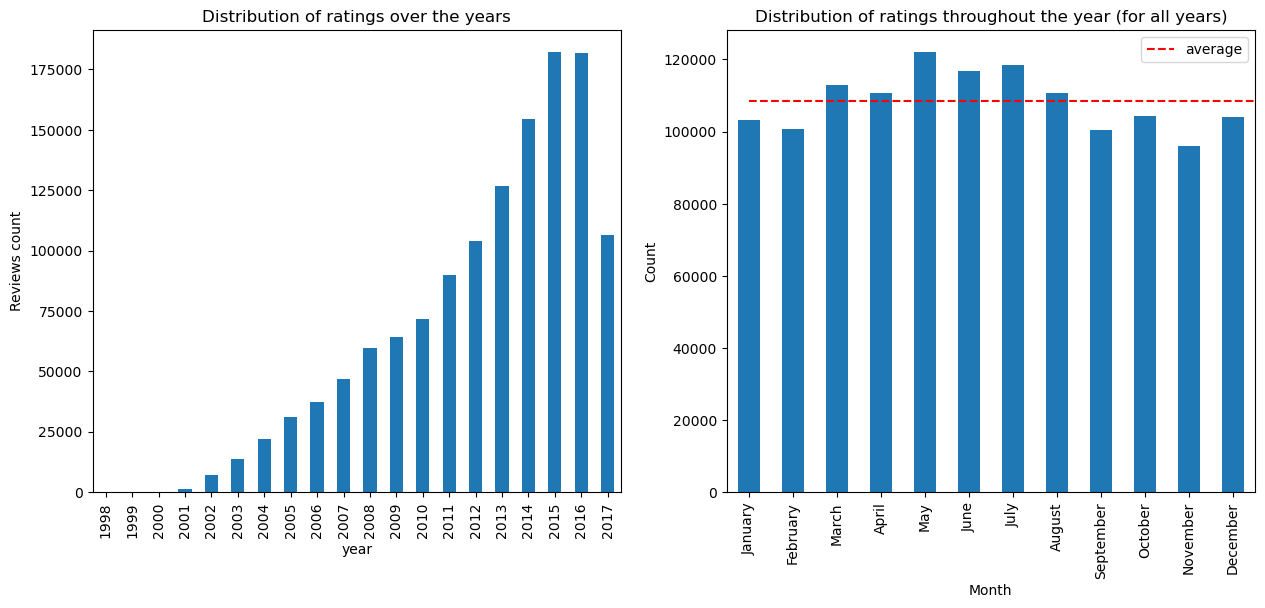

In [26]:
df_ratings_cleaned["date"] = pd.to_datetime(df_ratings_cleaned["date"])
fig, ax = plt.subplots(1,2, figsize=(15,6))
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.year).size().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribution of ratings over the years')
ax[0].set_xlabel('year')
ax[0].set_ylabel('Reviews count')
df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().plot(kind='bar', ax=ax[1])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax[1].plot([0,12],[df_ratings_cleaned.groupby(df_ratings_cleaned['date'].dt.month).size().apply('mean')]*2, color='red', linestyle='--', label='average')
ax[1].set_title('Distribution of ratings throughout the year (for all years)')
ax[1].set_xticklabels(months)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count')
ax[1].legend()
plt.show()

2. Distribution of ratings per style for a specefied country

> Here the goal is to provide quick insights of the distribution of the ratings for a selected country

Total # of ratings for Belgium: 26126


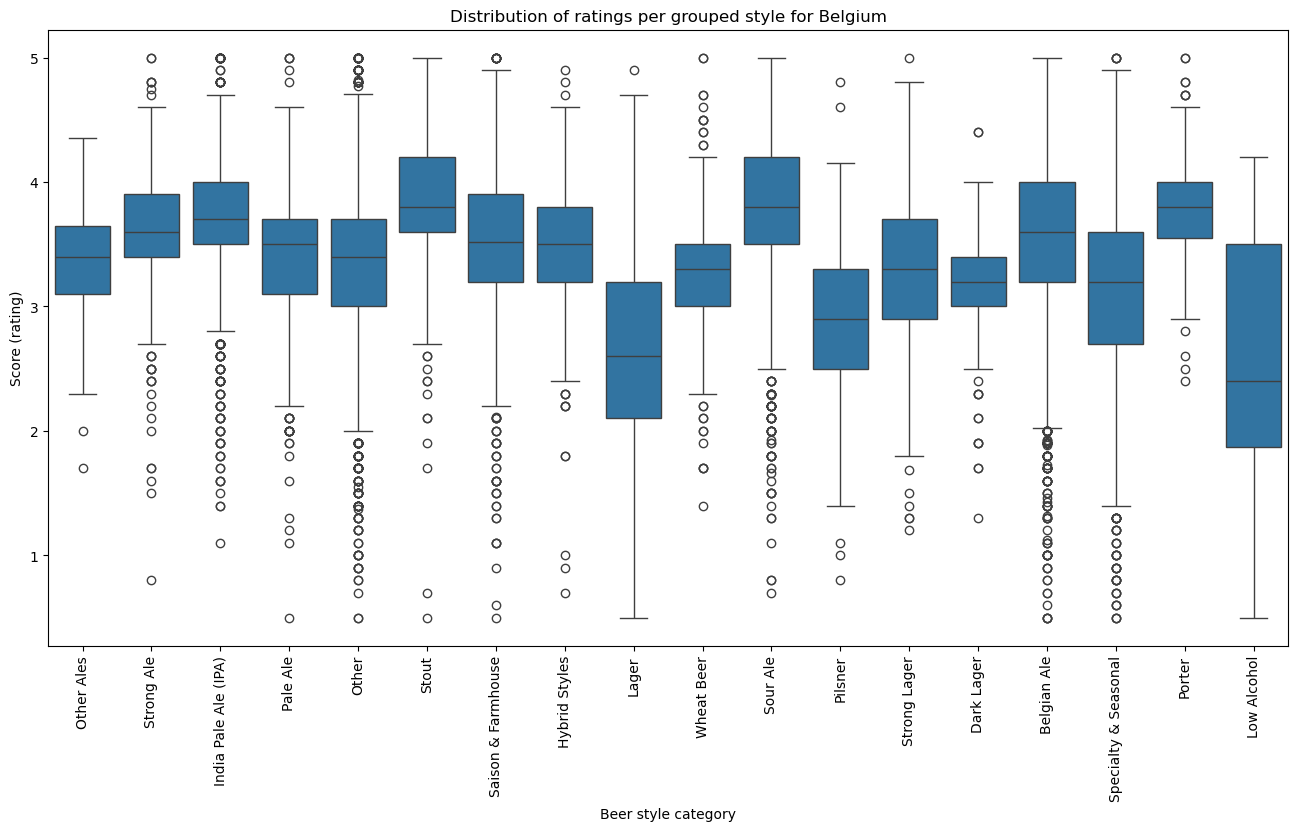

In [28]:
country = 'Belgium'
cols = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

df_selected_country = df_ratings_cleaned[df_ratings_cleaned.country_user == country]

print("Total # of ratings for {0}: {1}".format(country, df_selected_country['rating'].count()))

plt.figure(figsize=(16,8))
sns.boxplot(x='style_category', y='rating', data=df_selected_country)
plt.xticks(rotation=90)
plt.title('Distribution of ratings per grouped style for {0}'.format(country))
plt.xlabel('Beer style category')
plt.ylabel('Score (rating)')
plt.show()

3. Look at best rated beer style per country

In [29]:
def get_top_n(df, group, column, n): 
    return df.groupby(group).mean().sort_values(by=column,ascending=False)[:n]

cols = ['rating', 'overall', 'palate', 'taste', 'appearance', 'aroma', 'style_category']
df_ratings_cleaned.groupby(['country_user'])[cols].apply(get_top_n, group='style_category', column='rating', n=1)[['rating', 'overall', 'palate', 'taste', 'appearance', 'aroma']]


,,rating,overall,palate,taste,appearance,aroma
country_user,style_category,,,,,,
Abkhazia,Other,4.80,5.00,5.00,4.00,5.00,5.00
Afghanistan,Strong Ale,4.40,4.75,5.00,4.00,4.00,4.00
Albania,Other,5.00,5.00,5.00,5.00,5.00,5.00
Algeria,Strong Lager,3.90,4.00,3.00,4.50,4.00,3.50
Andorra,Wheat Beer,4.69,4.75,4.75,4.75,4.75,4.50
...,...,...,...,...,...,...,...
Uruguay,Pale Ale,4.10,4.25,5.00,4.00,4.00,3.50
Venezuela,Porter,3.75,4.00,3.50,3.75,3.00,3.75
Vietnam,India Pale Ale (IPA),4.28,4.42,4.08,4.25,4.08,4.25


# 3. Geospatial analysis
## 3.1.1 Climatic data

### Chelsa Data
The image is of size (20880, 43200, 3). Axis 2 is a repetition of the value, hence we get all the information we need with a (20880, 43200) array.

From the size of the image, the coordinates system used is:

- Projection: Geographic (latitude/longitude)
- Datum: WGS84 (World Geodetic System 1984)

The resolution is 30 arc seconds. When downsampling with a kernel size of 10, the resolution is ~5 arc minutes. This represents ~9.26 kilometers at the equator (should be enough for our data analysis).


In [34]:
# Import precipitation and temperature data
# Approximate runtime: 10 minutes
DATA_FOLDER = "../data/"
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

tmean_data = np.zeros((12, 2088, 4320))
prec_data = np.zeros((12, 2088, 4320))
tmin_data = np.zeros((12, 2088, 4320))
tmax_data = np.zeros((12, 2088, 4320))

for i, month in enumerate(months):

    tmean_file = geospatial_utils.load_geotiff(os.path.join(DATA_FOLDER, 'temp', f"CHELSA_tmean_2013_{month}_V1.2.1.tif"))
    prec_file = geospatial_utils.load_geotiff(os.path.join(DATA_FOLDER, 'prec', f"CHELSA_prec_2013_{month}_V1.2.1.tif"))
    # tmin_file = geospatial_utils.load_geotiff(os.path.join(DATA_FOLDER, 'min', f"CHELSA_tmin_2013_{month}_V1.2.1.tif"))
    # tmax_file = geospatial_utils.load_geotiff(os.path.join(DATA_FOLDER, 'max', f"CHELSA_tmax_2013_{month}_V1.2.1.tif"))

    tmean_data[i] = tmean_file
    prec_data[i] = prec_file
    # tmin_data[i] = tmin_file
    # tmax_data[i] = tmax_file

    # print(f"Processed month {month}\nmean temperature: {np.mean(tmean_data[i]):.2f}°C\nmean precipitation: {np.mean(prec_data[i]):.2f} mm\nmin temperature: {np.mean(tmin_data[i]):.2f}°C\nmax temperature: {np.mean(tmax_data[i]):.2f}°C\n")

# Convert temperature data to [°C]
tmean_data =  np.multiply(tmean_data, 1/10) - 273.15
# tmin_data =  np.multiply(tmin_data, 1/10) - 273.15
# tmax_data =  np.multiply(tmax_data, 1/10) - 273.15

## 3.1.2 Geographic rasters (maps of the world and of the us)

### Natural Earth datasets have the following properties:

- has a 'geometry' column containg data of type <class 'shapely.geometry.multipolygon.MultiPolygon'>
- Datum: WGS84 but given in unit of degrees

### We download two datasets:

- *ne_110m_admin_0_countries.shp* : contains geometries of every country in the world
- *ne_50m_admin_1_states_provinces.shp* : containes geometries of regions of some big countries. We are interested in the USA.

In [38]:
# Import world map (with region delimitation) and select desired columns
world_all = gpd.read_file(os.path.join(DATA_FOLDER, 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'))
# world_all = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world_all.loc[:, ['ADMIN', 'geometry']]

# Create Dataframe containing USA states only
# We remove the states of Hawaii and Alaska for visualization purpose and because we don't need them in our analysis
states_gdf = gpd.read_file(os.path.join(DATA_FOLDER, 'ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp'))
states_gdf_reduced = states_gdf.loc[:, ['admin', 'name', 'geometry']]
us = states_gdf_reduced[states_gdf_reduced['admin'] == 'United States of America']
us = us[us['name'] != 'Alaska']
us = us[us['name'] != 'Hawaii']

## 3.2 Geographical representation of beer preferences

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_10741/3406303990.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_FOLDER, 'cleaned_ratings.csv'))


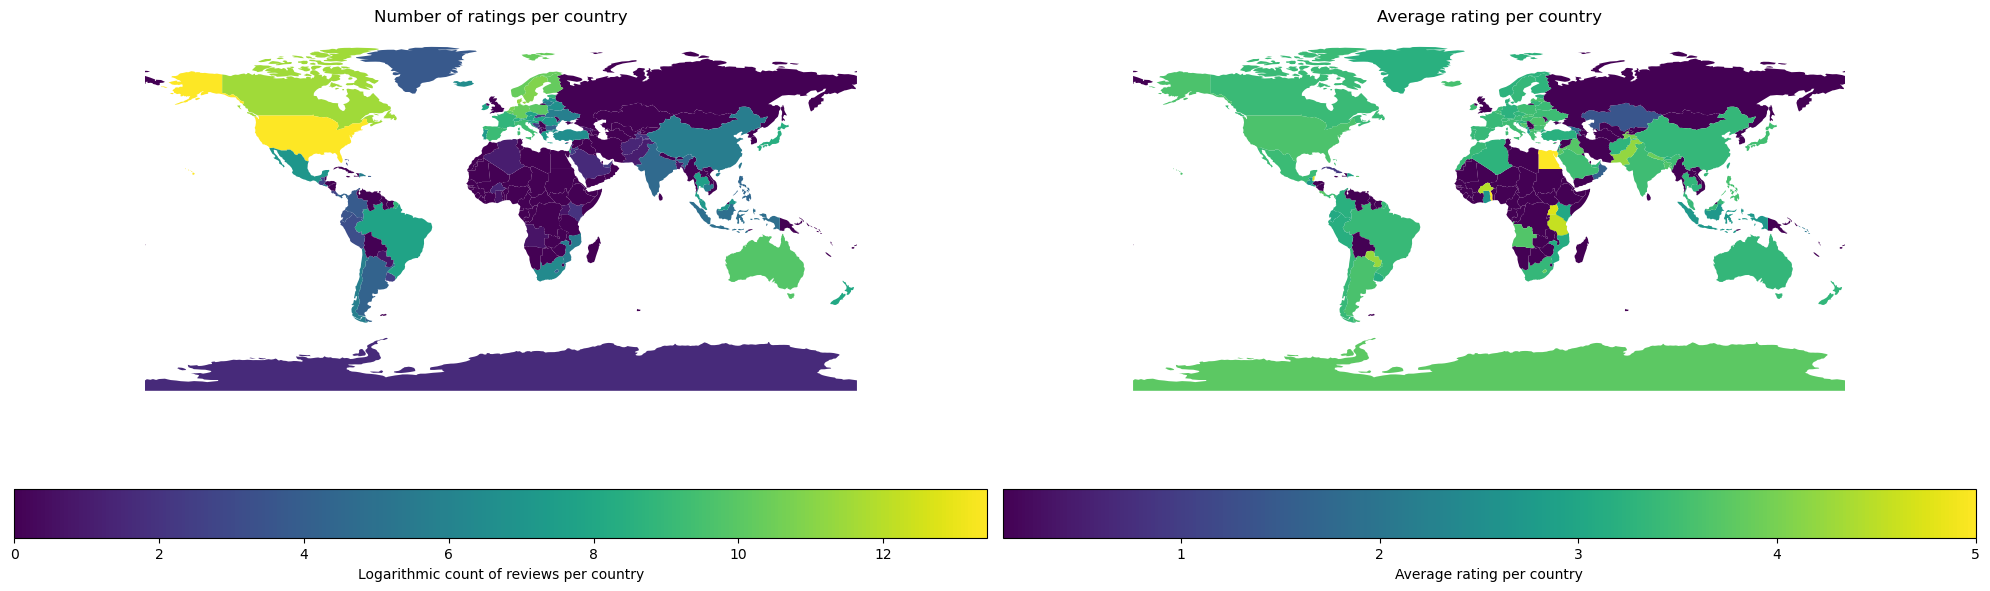

In [40]:
df = pd.read_csv(os.path.join(DATA_FOLDER, 'cleaned_ratings.csv'))
geo_df = geospatial_utils.generate_geodf(df, world)
geospatial_utils.plot_geodf(geo_df)

## 3.3 Seasonal variation of temperature in Belgium

When Bob will go on his roadtrip, he wants to choose his drink according to the weather in the capital of beers! Let's look what the temperature looks like year-round in Belgium.

Run the next cell to create an animation. If it does not display well in the notebook, the animation will be saved in the folder "animations".

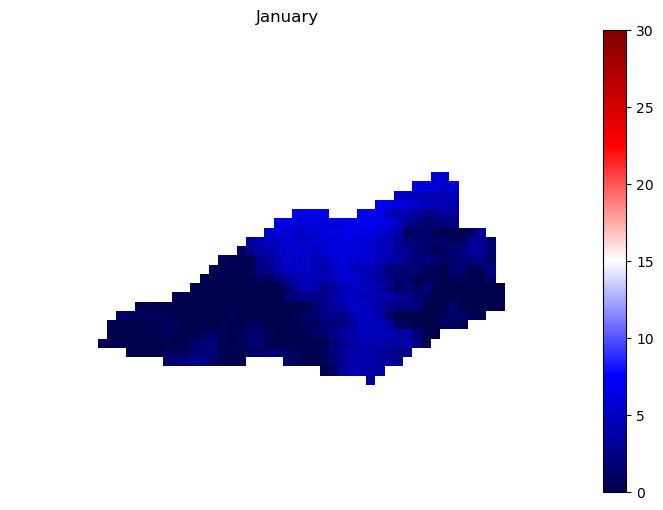

In [42]:
geospatial_utils.animation_belgium(world, tmean_data, 'temperature')

# 3.4 Weather differences across states in the USA

Next Bob visits the USA. What are the climatic differences across regions in the USA? 

To explore this question, the climatic data was interpolated across each region's geometric boundaries. An average was taken over each region to extract a single value per state.

First we generate a list of GeoDataFrame containing climatic data for each month of the year.

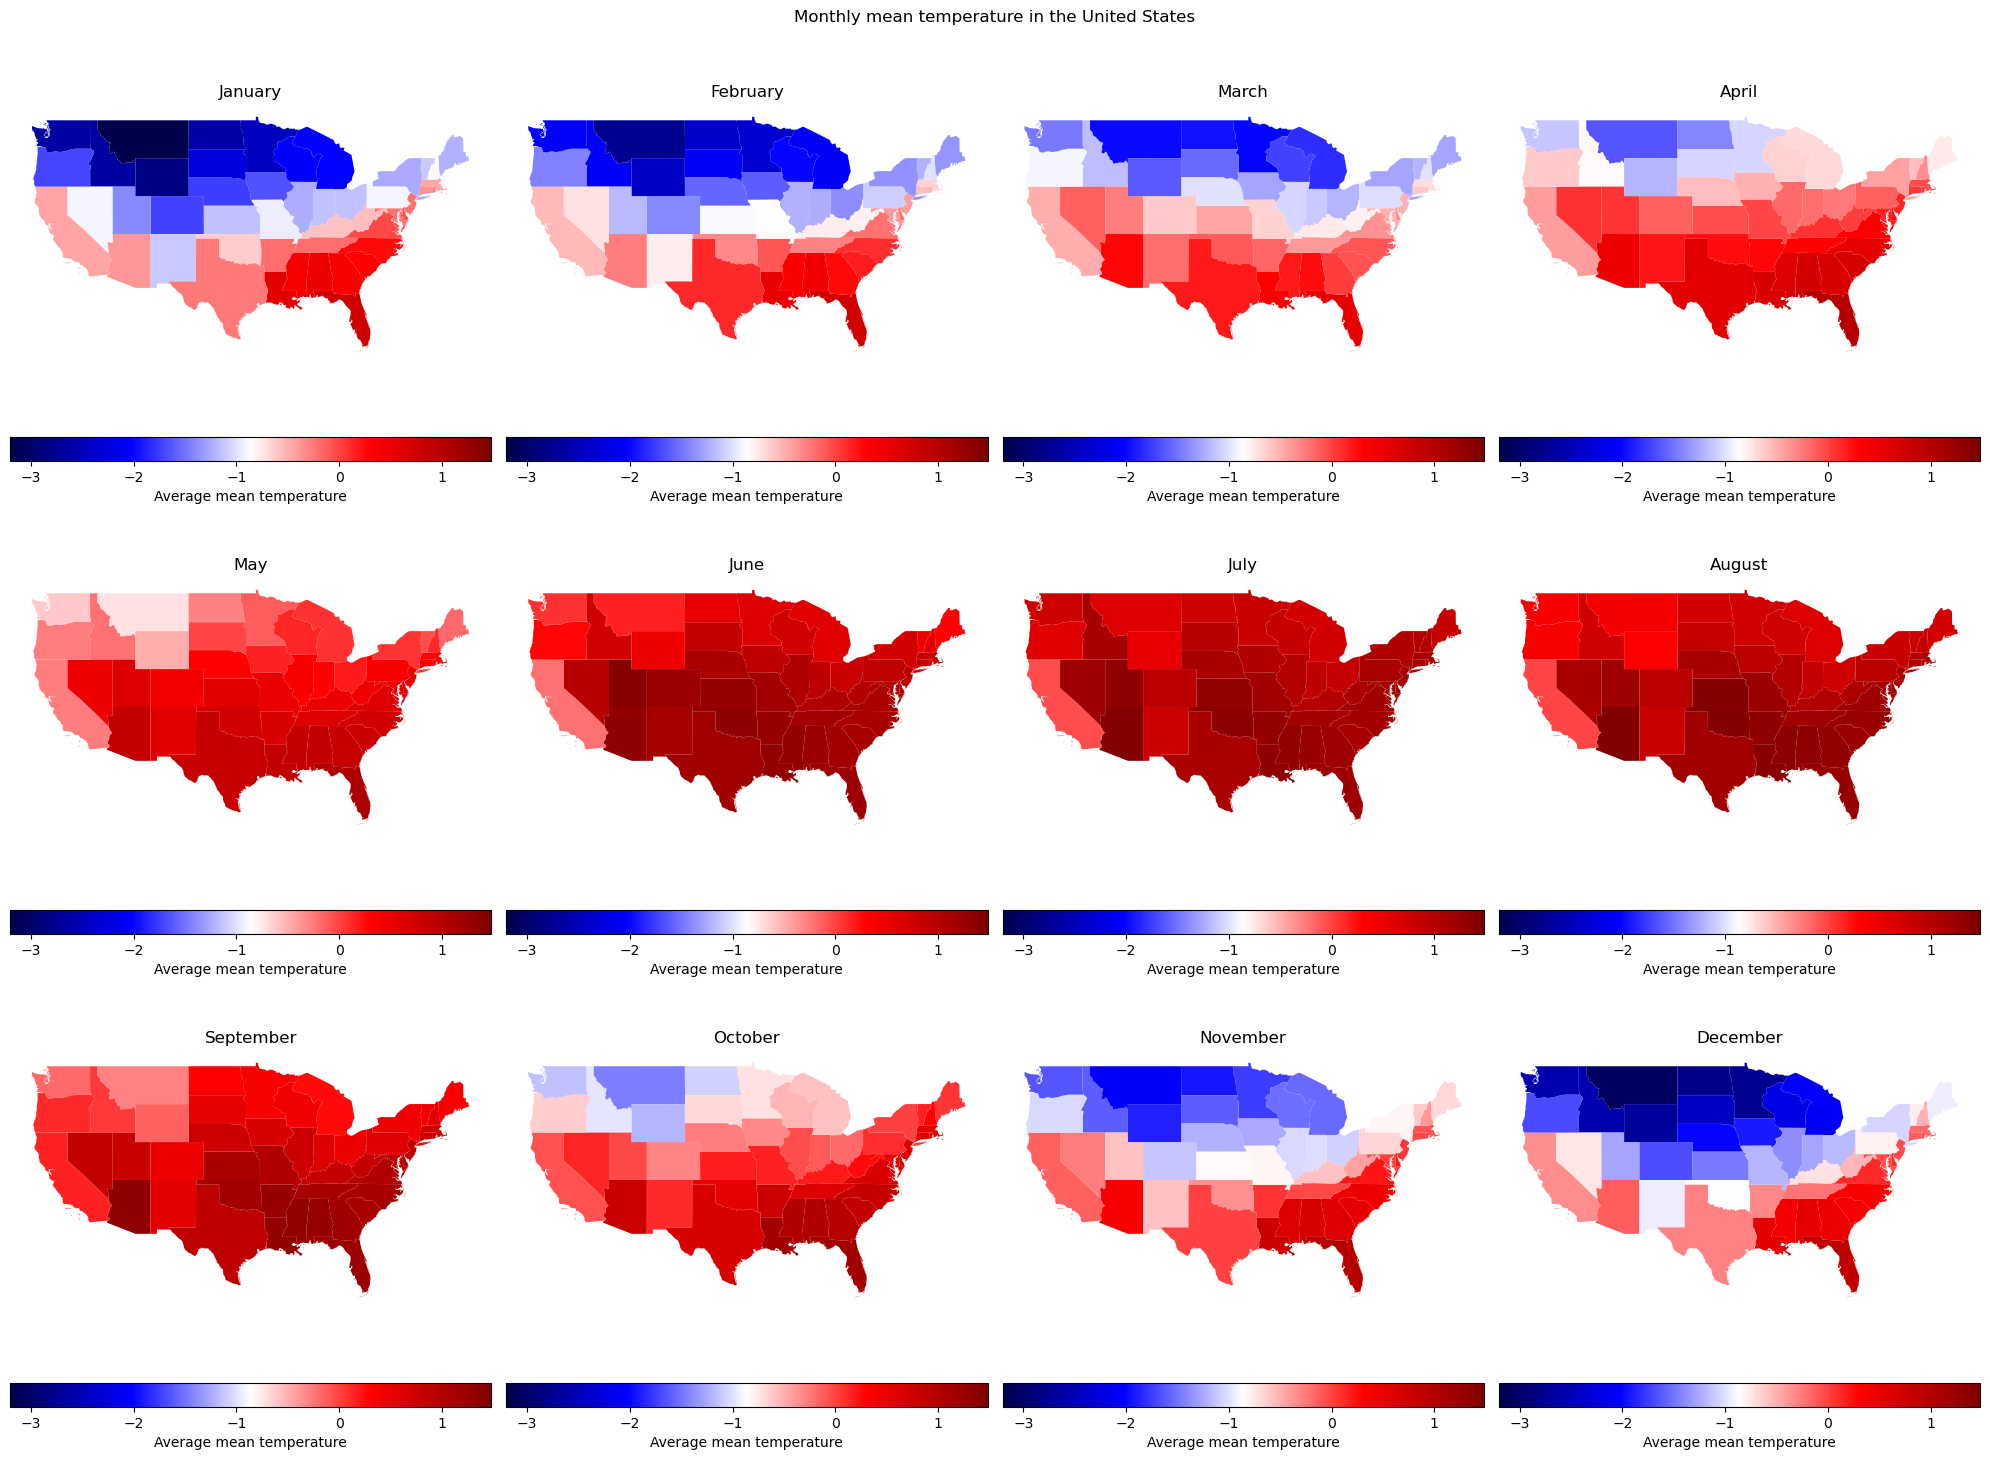

In [44]:
us_gdfs, t_stats, p_stats = geospatial_utils.generate_usgdfs(us, tmean_data, prec_data)
geospatial_utils.plot_usa(us_gdfs, 'tmean')

## 3.5. Similarity of weather between Switzerland and USA states
## 3.5.1 Interpolate climatic data in Switzerland

In [45]:
# Create vector of summary statistics for Switzerland
CH_monthly = np.zeros(24)
CH_monthly_st = np.zeros(24)

CH = world[world['ADMIN'] == 'Switzerland']

for i in range(12):

    mean_t = geospatial_utils.interpolate_temp(tmean_data[i], CH)
    mean_p = geospatial_utils.interpolate_temp(prec_data[i], CH)

    CH_monthly[i] = mean_t[0]
    CH_monthly[i + 12] = mean_p[0] 


### 3.5.2 Append it to USA data and normalize the whole data

In [46]:
_ = np.newaxis

us_comp = np.concatenate((t_stats, p_stats), axis=0)
comp_data = np.concatenate((CH_monthly[:,_], us_comp), axis=1)

av_tmean_comp = np.mean(comp_data[:12,:])
std_tmean_comp = np.std(comp_data[:12,:])
av_prec_comp = np.mean(comp_data[12:,:])
std_prec_comp = np.std(comp_data[12:,:])

comp_data_norm = np.zeros(comp_data.shape)
comp_data_norm[:12,:] = (comp_data[:12,:] - av_tmean_comp) / std_tmean_comp
comp_data_norm[12:,:] = (comp_data[12:,:] - av_prec_comp) / std_prec_comp

Then we iterate over all columns of the array, and compute the similarity score with the swiss climate. To compute similarity we use the L2 norm of the difference. The smaller the norm, the more similar the climate. Then we sort the dataframe based on the score and display the top 5 matches for Switzerland's climate.

In [47]:
state_names = us['name']
state_names = state_names.values

best_score = 100000
best_idx = 0
scores = []

for j in range(1, comp_data_norm.shape[1]-1):
    # Compute L2 norm difference
    diff_vector = comp_data_norm[:,0] - comp_data_norm[:,j]
    score = np.linalg.norm(diff_vector)
    scores.append(score)

    if score < best_score:
        best_score = score
        best_idx = j

results = zip(state_names, scores)
df_results = pd.DataFrame(results, columns=['state_name', 'score'])

df_results
df_sorted = df_results.sort_values(by='score')
df_sorted.iloc[:5,:]


,state_name,score
32,New York,1.71
28,New Hampshire,2.05
44,Vermont,2.11
19,Maine,2.22
18,Maryland,2.22


We see that the states with the most similar climate is New York, New Hampshire, Vermont, Maine and Maryland. From what we know, this seems to make sense!